In [1]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [2]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
     
    if trim is not None:
        image_paths = image_paths[:trim]
        


                
    if mask:
        
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
     
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256
root_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [6]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [7]:

image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

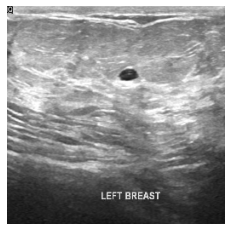

In [8]:

show_image(load_image(image_paths[0], SIZE))

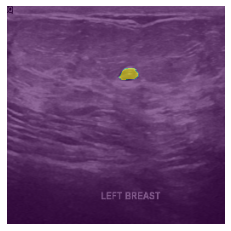

In [9]:

show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

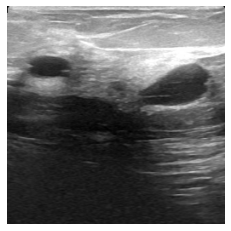

In [10]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

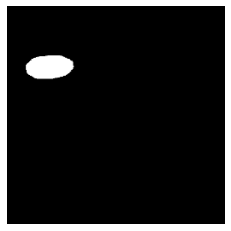

In [11]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

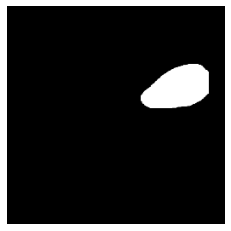

In [12]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

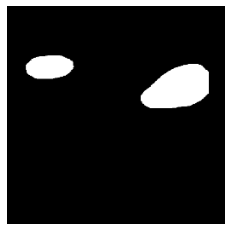

In [13]:
img = np.zeros((1,SIZE,SIZE,3)) 
mask1 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2 
img = img[0,:,:,0] 

show_image(img, cmap='gray')

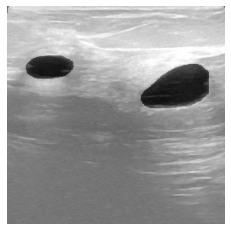

In [14]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

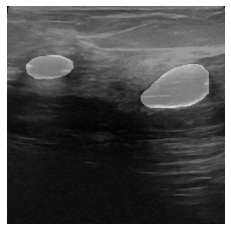

In [15]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

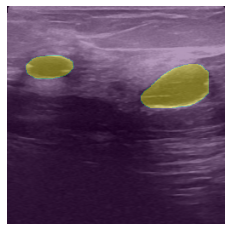

In [16]:
show_image(load_image('../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

## **Data Work**

In [17]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

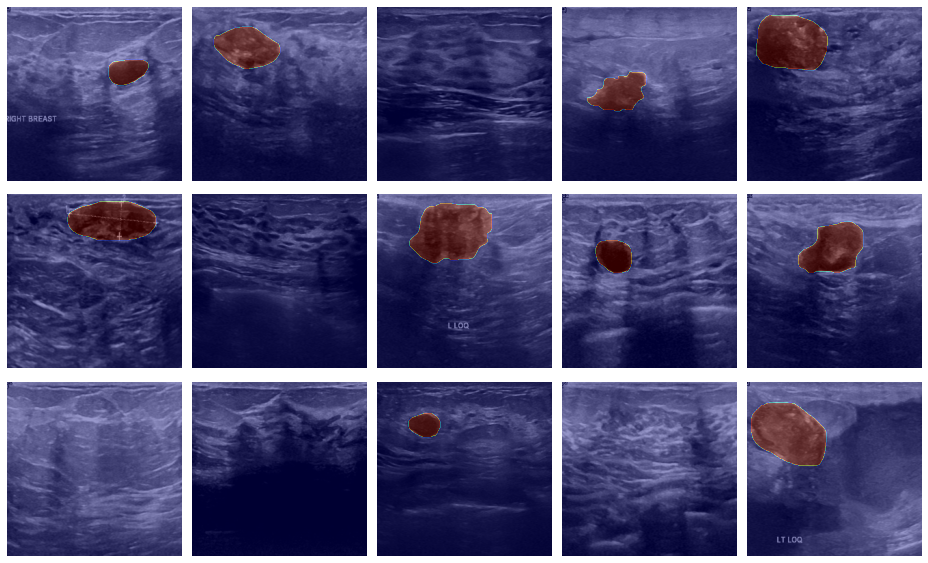

In [18]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

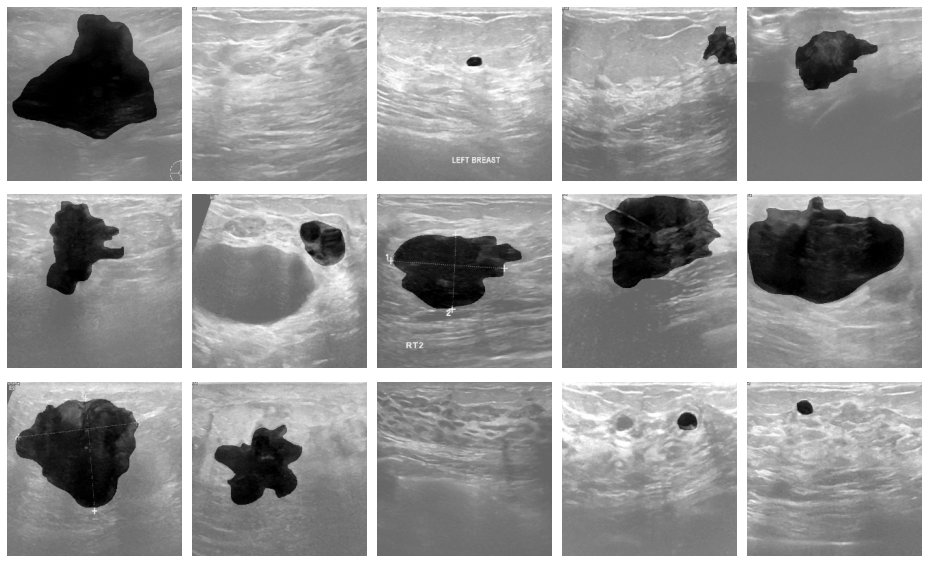

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

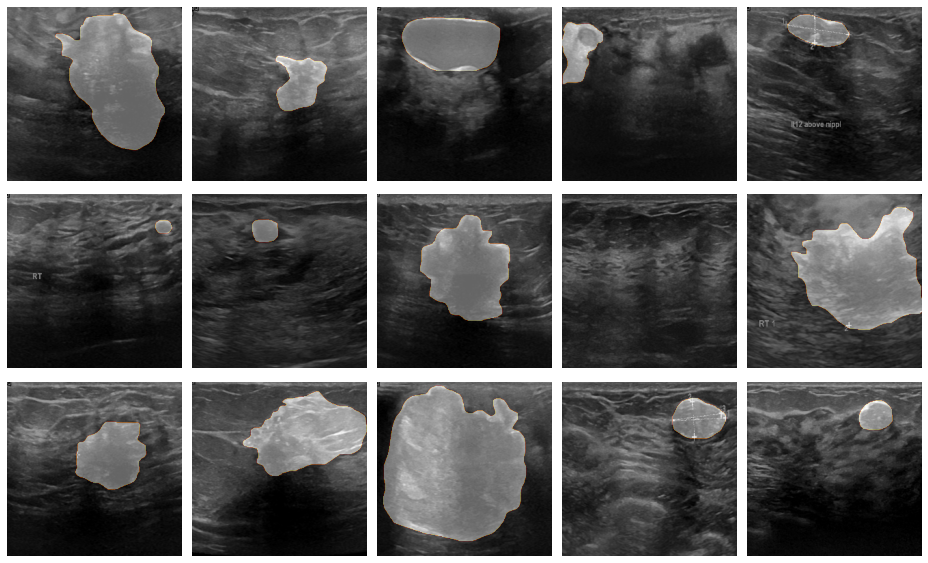

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

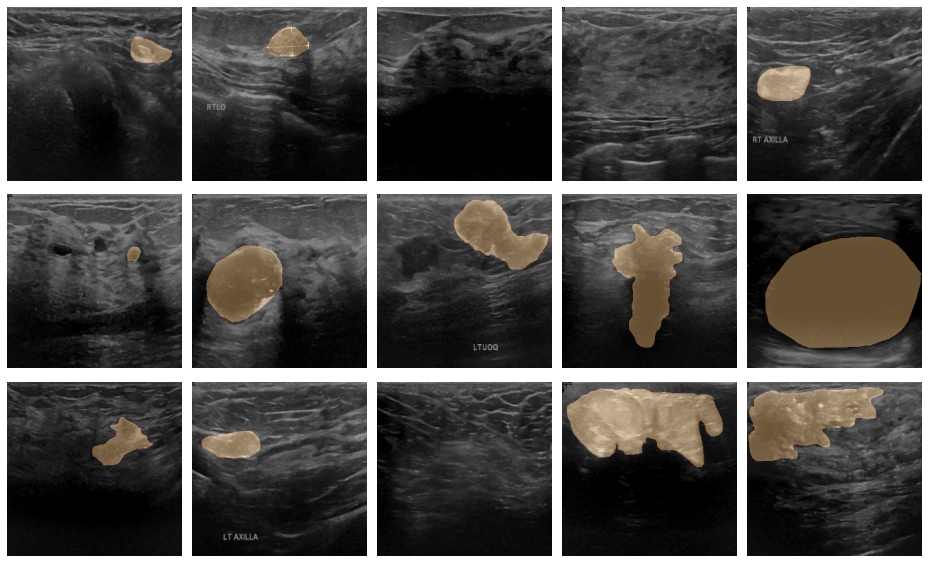

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [23]:
 class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', 
                        activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', 
                        activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        }

In [24]:
class DecoderBlock(Layer):
    
    def __init__(self, filters, rate, **kwargs):
         
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X 
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [25]:
class AttentionGate(Layer):
    
    def __init__(self, filters, bn, **kwargs):
         
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip]) 
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X]) 
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [26]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
         
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

Epoch 1/20
97/97 [==============================] - 26s 148ms/step - loss: 0.4055 - accuracy: 0.8982 - IoU: 0.4536 - val_loss: 0.3094 - val_accuracy: 0.9813 - val_IoU: 0.4909


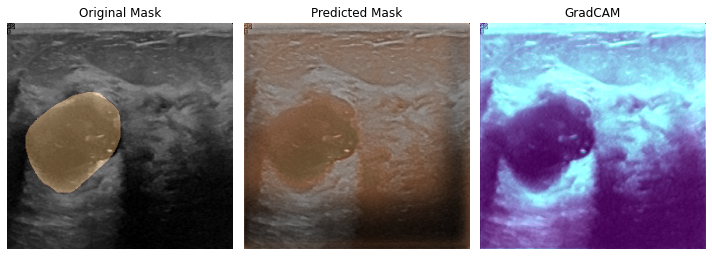

Epoch 2/20
97/97 [==============================] - 13s 131ms/step - loss: 0.2173 - accuracy: 0.9189 - IoU: 0.4547 - val_loss: 0.1364 - val_accuracy: 0.9814 - val_IoU: 0.4909


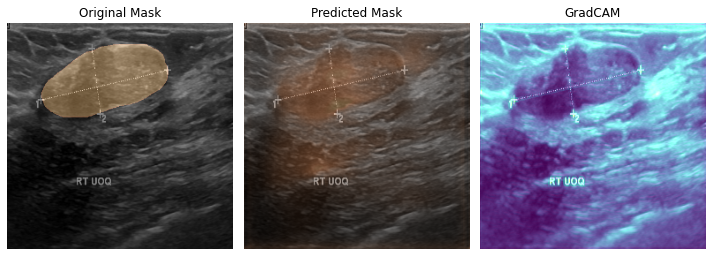

Epoch 3/20
97/97 [==============================] - 13s 131ms/step - loss: 0.2053 - accuracy: 0.9237 - IoU: 0.4557 - val_loss: 0.0851 - val_accuracy: 0.9813 - val_IoU: 0.4909


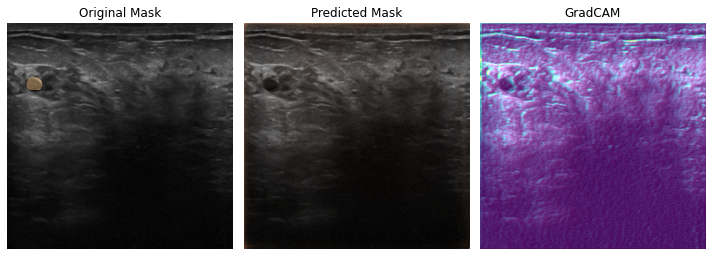

Epoch 4/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1980 - accuracy: 0.9268 - IoU: 0.4552 - val_loss: 0.0820 - val_accuracy: 0.9813 - val_IoU: 0.4909


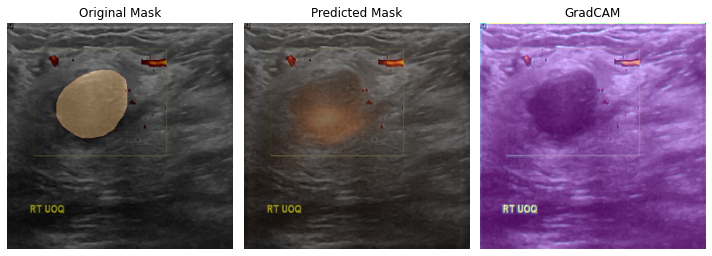

Epoch 5/20
97/97 [==============================] - 13s 132ms/step - loss: 0.1877 - accuracy: 0.9310 - IoU: 0.4546 - val_loss: 0.0682 - val_accuracy: 0.9828 - val_IoU: 0.4909


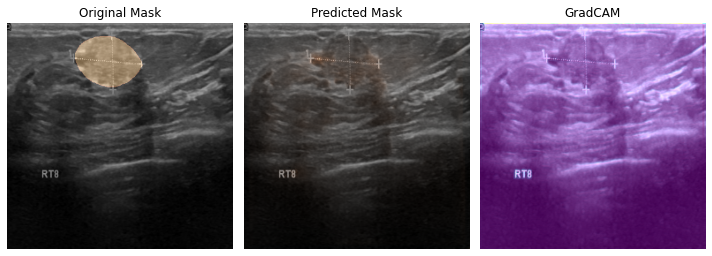

Epoch 6/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1782 - accuracy: 0.9347 - IoU: 0.4544 - val_loss: 0.0663 - val_accuracy: 0.9831 - val_IoU: 0.4909


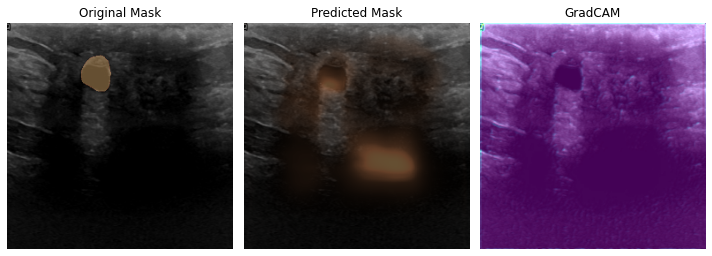

Epoch 7/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1719 - accuracy: 0.9380 - IoU: 0.4551 - val_loss: 0.0693 - val_accuracy: 0.9817 - val_IoU: 0.4909


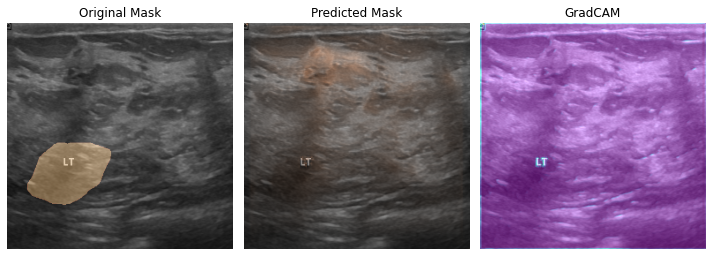

Epoch 8/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1658 - accuracy: 0.9381 - IoU: 0.4540 - val_loss: 0.0755 - val_accuracy: 0.9824 - val_IoU: 0.4909


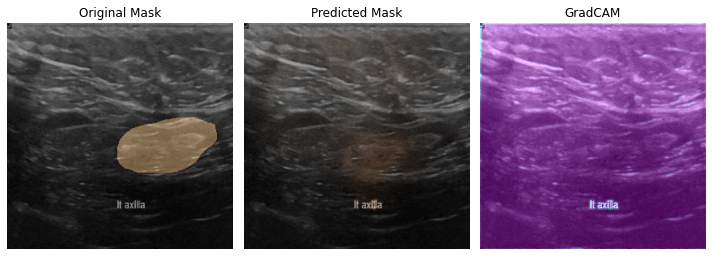

Epoch 9/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1538 - accuracy: 0.9446 - IoU: 0.4563 - val_loss: 0.0646 - val_accuracy: 0.9837 - val_IoU: 0.4909


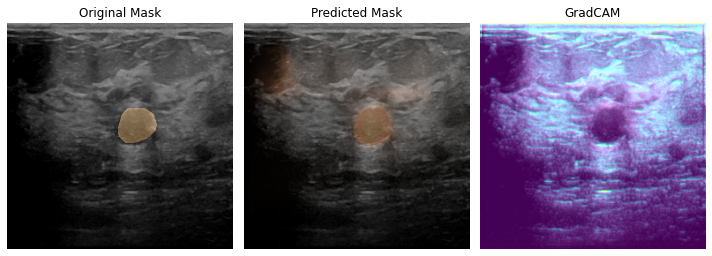

Epoch 10/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1494 - accuracy: 0.9451 - IoU: 0.4538 - val_loss: 0.0557 - val_accuracy: 0.9850 - val_IoU: 0.4909


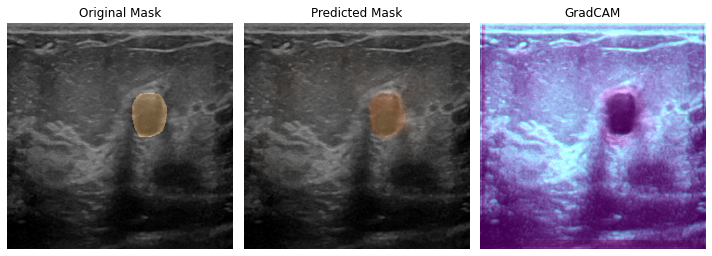

Epoch 11/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1407 - accuracy: 0.9482 - IoU: 0.4550 - val_loss: 0.0609 - val_accuracy: 0.9850 - val_IoU: 0.4909


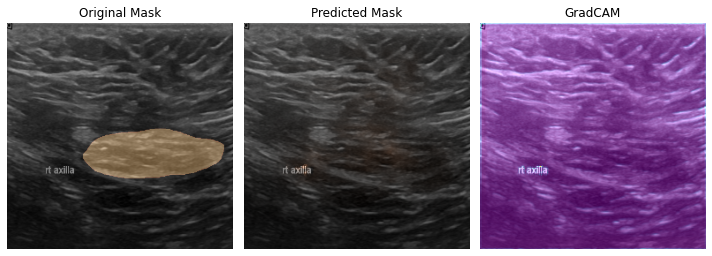

Epoch 12/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1389 - accuracy: 0.9494 - IoU: 0.4556 - val_loss: 0.0631 - val_accuracy: 0.9818 - val_IoU: 0.4909


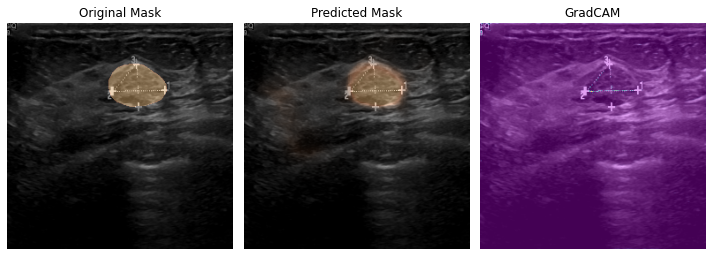

Epoch 13/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1342 - accuracy: 0.9505 - IoU: 0.4556 - val_loss: 0.0595 - val_accuracy: 0.9839 - val_IoU: 0.4909


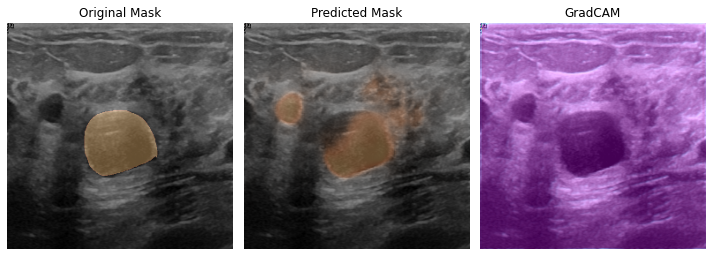

Epoch 14/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1290 - accuracy: 0.9525 - IoU: 0.4557 - val_loss: 0.0828 - val_accuracy: 0.9750 - val_IoU: 0.4912


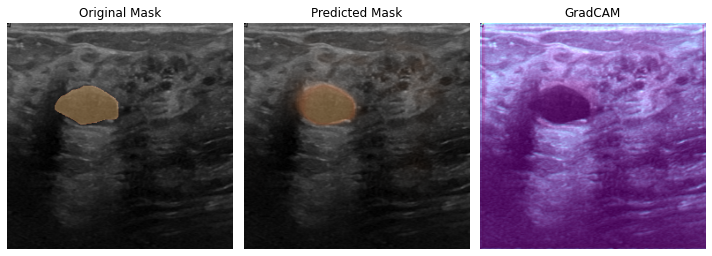

Epoch 15/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1249 - accuracy: 0.9534 - IoU: 0.4559 - val_loss: 0.0674 - val_accuracy: 0.9814 - val_IoU: 0.4909


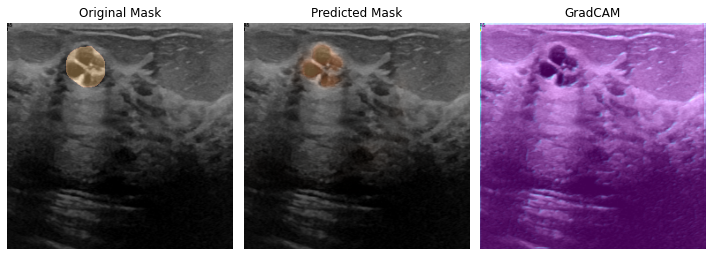

Epoch 16/20
97/97 [==============================] - 13s 131ms/step - loss: 0.1270 - accuracy: 0.9526 - IoU: 0.4537 - val_loss: 0.1590 - val_accuracy: 0.9476 - val_IoU: 0.4909


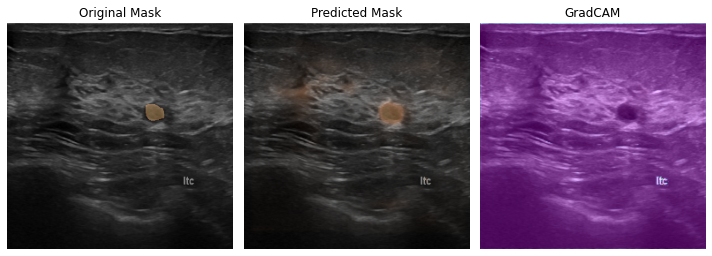

Epoch 17/20
97/97 [==============================] - 2s 16ms/step - loss: 0.1385 - accuracy: 0.9489 - IoU: 0.4519 - val_loss: 0.0593 - val_accuracy: 0.9859 - val_IoU: 0.4909


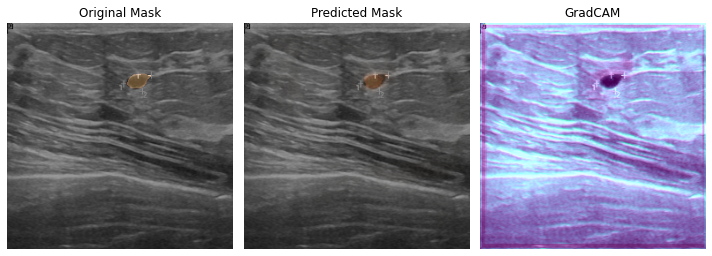

In [28]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2, 
    epochs=20, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE, 
    batch_size=BATCH_SIZE, 
    callbacks=cb 
)

In [29]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

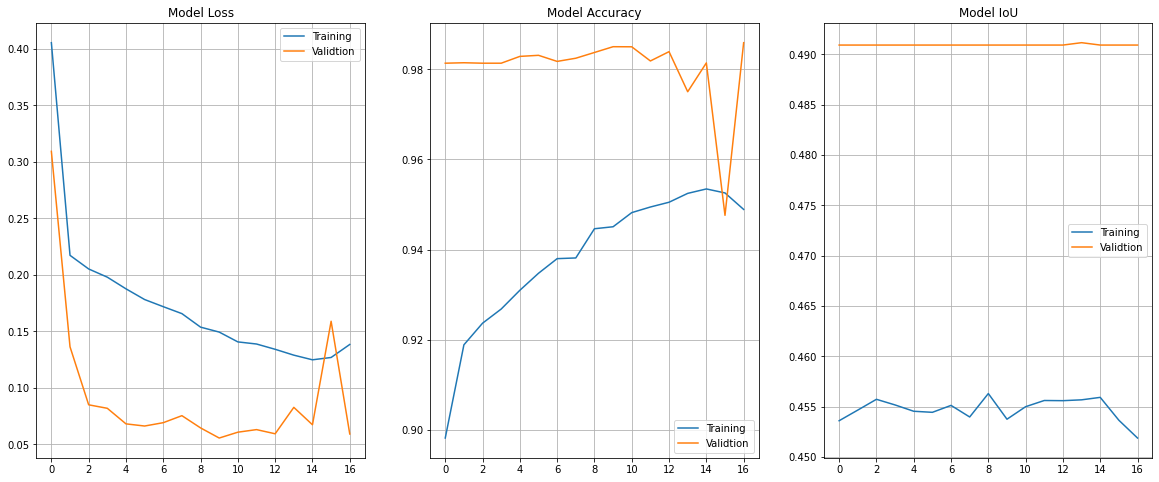

In [30]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

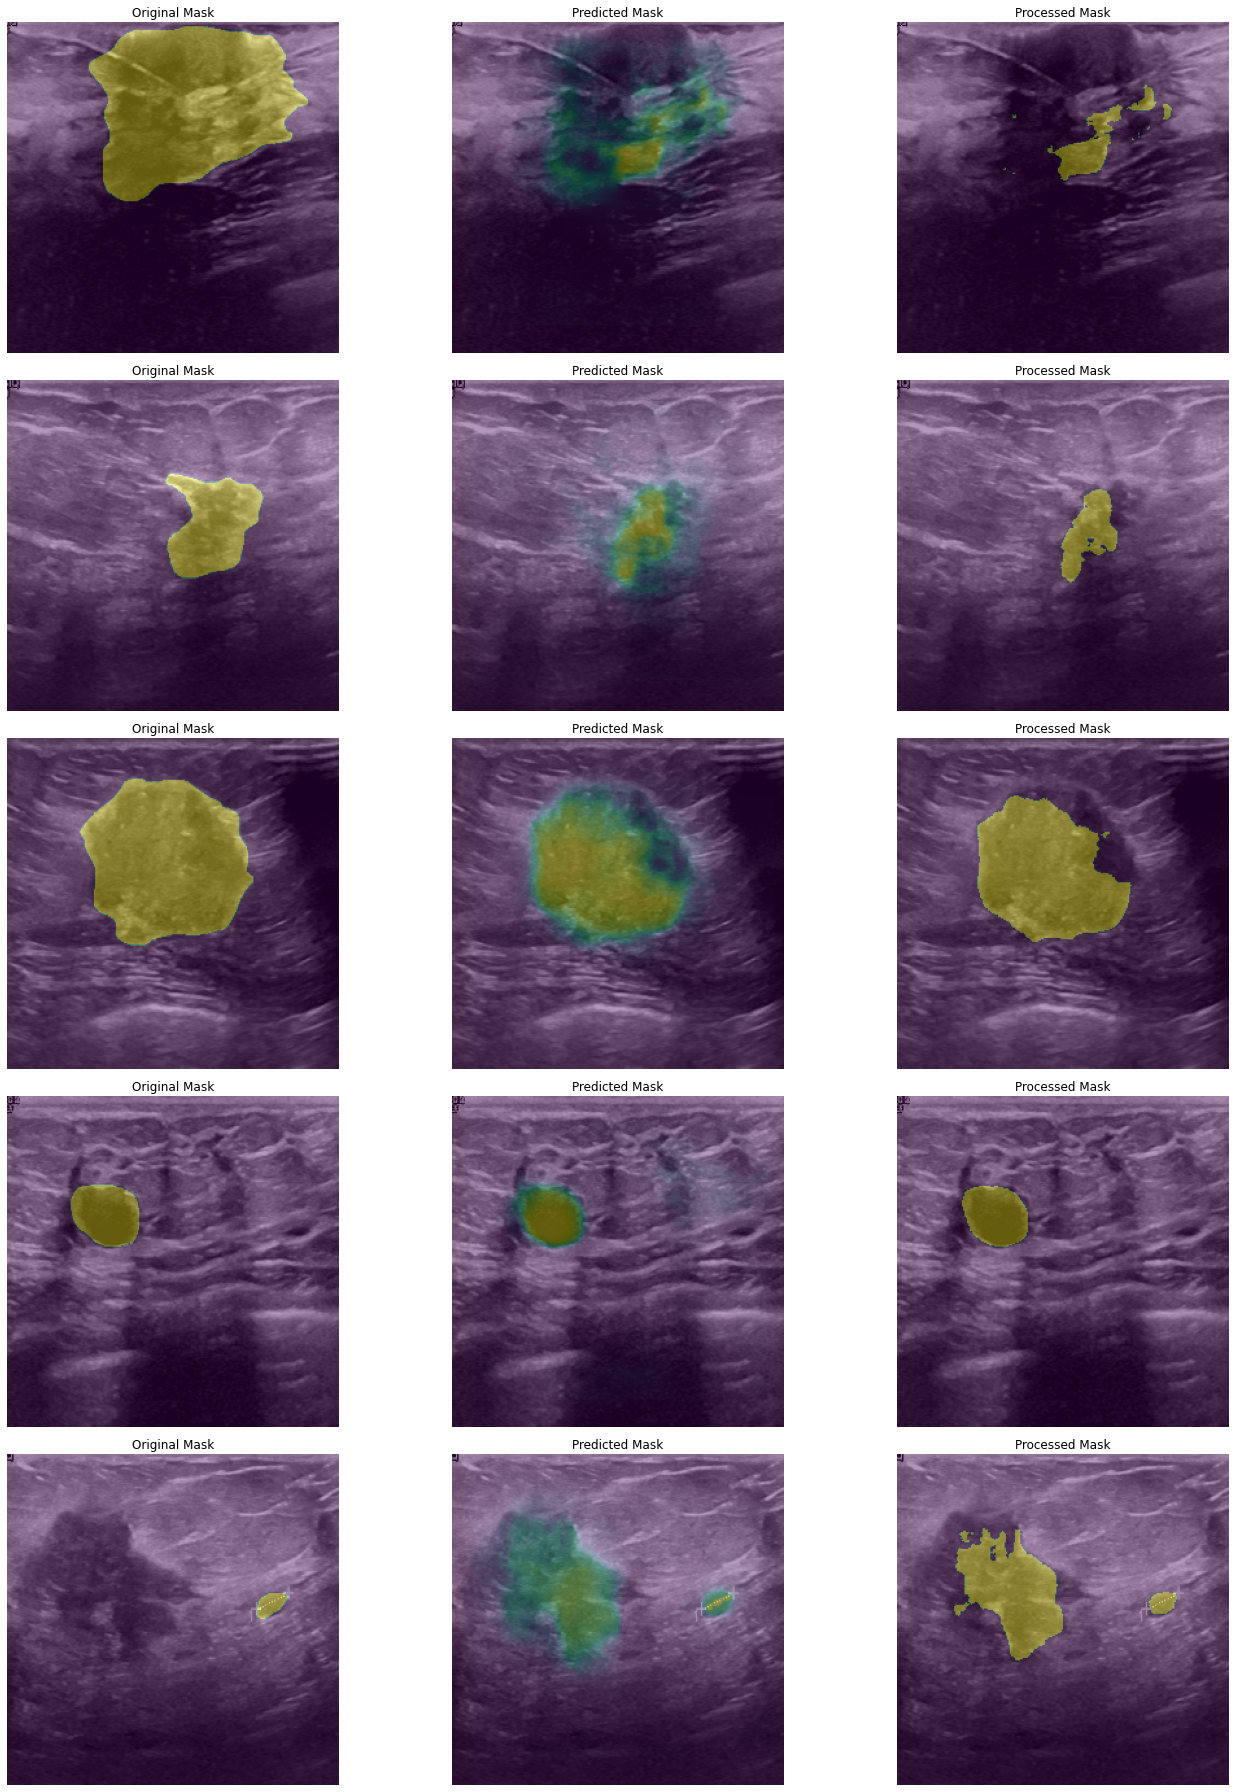

In [31]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()